In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import osmnx as ox
import json

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cseadmin/dz/TrafficFlowModel/data_process/gis_pipeline'

In [2]:
DATA_PATH = "../../data/"
TAXI_DATA_PATH = "../../data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"

MIN_LAT = 22.5311
MAX_LAT = 22.5517
MIN_LNG = 114.0439
MAX_LNG = 114.0633

DATE_PREFIX = "2020-06-"
START_DAY = 1
END_DAY = 30

DOWNSAMPLING_INTERVAL = 30
TRAJ_SPLIT_INTERVAL = 600
FLOW_AGG_INTERVAL_MINUTE = 5 # TODO 5min

def notify(msg):
    import datetime
    channel = "J0budaR2THarZw0OqS5O"
    notify_url = f"https://notify.run/{channel}"
    massage = f"{msg} | {str(datetime.datetime.now())}"
    os.system(f'curl {notify_url} -d "{massage}"')

In [50]:
a=np.array([0, 1], dtype=np.int16)
b=a.view(np.float16) # will always use same mem location (i.e. pointer &a==&b), and treat b as float array
print(a)
print(b)
b[0]=1.5
print(a)
print(b)
print("---")
a=np.array([0, 1], dtype=np.int16)
b=a.astype(np.float16, copy=False) # will still copy because int cannot be directly converted to float
print(a)
print(b)
b[0]=1.5
print(a)
print(b)
print("---")
a=np.array([0, 1], dtype=np.int16)
b=a.astype(np.int16, copy=False) # will not copy
print(a)
print(b)
b[0]=1.5
print(a)
print(b)

[0 1]
[0.e+00 6.e-08]
[15872     1]
[1.5e+00 6.0e-08]
---
[0 1]
[0. 1.]
[0 1]
[1.5 1. ]
---
[0 1]
[0 1]
[1 1]
[1 1]


geo

---

In [3]:
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

df_edges

,fid,u,v,geometry
0,0,39,105,"LINESTRING (114.04424 22.55066, 114.04424 22.5..."
1,1,129,36,"LINESTRING (114.04761 22.55094, 114.04768 22.5..."
2,2,36,68,"LINESTRING (114.04768 22.54928, 114.04667 22.5..."
3,3,68,10,"LINESTRING (114.04667 22.54928, 114.04665 22.5..."
4,4,39,10,"LINESTRING (114.04424 22.55066, 114.04665 22.5..."
...,...,...,...,...
487,487,79,45,"LINESTRING (114.06304 22.53372, 114.06297 22.5..."
488,488,73,79,"LINESTRING (114.06305 22.53176, 114.06304 22.5..."
489,489,102,79,"LINESTRING (114.06133 22.53171, 114.06304 22.5..."
490,490,102,73,"LINESTRING (114.06133 22.53171, 114.06305 22.5..."


In [4]:
df_geo=pd.DataFrame()

df_geo["geo_id"]=df_edges["fid"]
df_geo["type"]="LineString"
df_geo["coordinates"]=df_edges["geometry"].apply(lambda x: list(x.coords))

df_geo

,geo_id,type,coordinates
0,0,LineString,"[(114.04423924729905, 22.550663183705367), (11..."
1,1,LineString,"[(114.04761345337049, 22.550935297098224), (11..."
2,2,LineString,"[(114.04767694649549, 22.54928447584822), (114..."
3,3,LineString,"[(114.0466701269419, 22.54928447584822), (114...."
4,4,LineString,"[(114.04423924729905, 22.550663183705367), (11..."
...,...,...,...
487,487,LineString,"[(114.06303991233369, 22.533716708739618), (11..."
488,488,LineString,"[(114.06305083168648, 22.531762144591667), (11..."
489,489,LineString,"[(114.06132557394695, 22.531707547827757), (11..."
490,490,LineString,"[(114.06132557394695, 22.531707547827757), (11..."


In [5]:
df_geo.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.geo"), index=False)

rel

---

In [6]:
rel=[]
rel_id_counter=0

u_dict={}

for _, row in df_edges.iterrows():
    if row["u"] not in u_dict.keys():
        u_dict[row["u"]]=[]
    u_dict[row["u"]].append(row["fid"])
    
for _, row in df_edges.iterrows():
    for adj_fid in u_dict[row["v"]]:
        rel.append([rel_id_counter, "geo", row["fid"], adj_fid])
        rel_id_counter+=1

df_rel=pd.DataFrame(rel, columns=["rel_id", "type", "origin_id", "destination_id"])

df_rel

,rel_id,type,origin_id,destination_id
0,0,geo,0,70
1,1,geo,0,246
2,2,geo,0,252
3,3,geo,1,2
4,4,geo,1,63
...,...,...,...,...
1689,1689,geo,490,244
1690,1690,geo,490,488
1691,1691,geo,491,245
1692,1692,geo,491,489


In [8]:
df_rel.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.rel"), index=False)

dyna

---

In [4]:
df_fmm_res=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "mr.txt"), sep=";").set_index("id").dropna()
df_fmm_data=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "gps.csv"), sep=";", parse_dates=["time"])

df_fmm_res
df_fmm_data

,opath,cpath,mgeom
id,,,
78132,"244,476,447","244,245,477,476,209,210,211,447","LINESTRING(114.062939001 22.5317586056,114.061..."
81256,"488,488",488,"LINESTRING(114.063049678 22.5319686462,114.063..."
79694,"19,269","19,269","LINESTRING(114.062691727 22.5502455229,114.062..."
57826,"443,435","443,435","LINESTRING(114.044581738 22.5329280644,114.044..."
93752,"211,443","211,202,445,444,443","LINESTRING(114.051461116 22.5315229562,114.051..."
...,...,...,...
1906027,"444,444",444,"LINESTRING(114.047618321 22.5314890507,114.046..."
1906028,"190,191,434","190,191,187,434","LINESTRING(114.045760819 22.5333764018,114.045..."
1906029,"386,389,363,300,47","386,391,389,142,351,363,362,355,303,300,298,29...","LINESTRING(114.044990728 22.5407215039,114.045..."


,id,x,y,time
0,0,114.050660,22.551142,2020-06-01 10:07:21
1,0,114.050690,22.551117,2020-06-01 10:08:36
2,0,114.054720,22.551180,2020-06-01 10:09:07
3,0,114.057950,22.546215,2020-06-01 10:11:22
4,0,114.059260,22.545100,2020-06-01 10:12:14
...,...,...,...,...
15645397,1996492,114.044890,22.531273,2020-06-30 10:40:31
15645398,1996492,114.060360,22.531437,2020-06-30 10:41:50
15645399,1996492,114.063095,22.533310,2020-06-30 10:45:01
15645400,1996493,114.062830,22.531683,2020-06-30 11:42:00


In [5]:
def convert_path(row):
    row["opath"]=np.array(row["opath"].split(","), dtype=np.int16)
    row["cpath"]=np.array(row["cpath"].split(","), dtype=np.int16)
    
    return row

df_fmm_res=df_fmm_res.apply(convert_path, axis=1)

df_fmm_res

,opath,cpath,mgeom
id,,,
78132,"[244, 476, 447]","[244, 245, 477, 476, 209, 210, 211, 447]","LINESTRING(114.062939001 22.5317586056,114.061..."
81256,"[488, 488]",[488],"LINESTRING(114.063049678 22.5319686462,114.063..."
79694,"[19, 269]","[19, 269]","LINESTRING(114.062691727 22.5502455229,114.062..."
57826,"[443, 435]","[443, 435]","LINESTRING(114.044581738 22.5329280644,114.044..."
93752,"[211, 443]","[211, 202, 445, 444, 443]","LINESTRING(114.051461116 22.5315229562,114.051..."
...,...,...,...
1906027,"[444, 444]",[444],"LINESTRING(114.047618321 22.5314890507,114.046..."
1906028,"[190, 191, 434]","[190, 191, 187, 434]","LINESTRING(114.045760819 22.5333764018,114.045..."
1906029,"[386, 389, 363, 300, 47]","[386, 391, 389, 142, 351, 363, 362, 355, 303, ...","LINESTRING(114.044990728 22.5407215039,114.045..."


array(['2020-06-01T19:00:07.000000000', '2020-06-01T19:01:47.000000000',
       '2020-06-01T19:05:17.000000000', '2020-06-01T19:06:06.000000000',
       '2020-06-01T19:08:07.000000000', '2020-06-01T19:09:47.000000000',
       '2020-06-01T19:10:47.000000000', '2020-06-01T19:12:06.000000000',
       '2020-06-01T19:13:59.000000000', '2020-06-01T19:14:29.000000000',
       '2020-06-01T19:15:07.000000000', '2020-06-01T19:15:46.000000000',
       '2020-06-01T19:17:10.000000000', '2020-06-01T19:22:26.000000000',
       '2020-06-01T19:23:36.000000000', '2020-06-01T19:24:26.000000000',
       '2020-06-01T19:34:01.000000000'], dtype='datetime64[ns]')

array([444, 456, 474, 473, 234, 459, 451, 425, 168, 328, 326,  80,  81,
        81, 327, 327,  81], dtype=int16)

array([444, 198, 199, 448, 457, 456, 455, 474, 473, 224, 234, 480, 470,
       459, 458, 451, 449, 180, 425, 168, 410, 328, 327, 326,  80,  81,
       327,  81, 327,  81], dtype=int16)

<AxesSubplot:>

<AxesSubplot:>

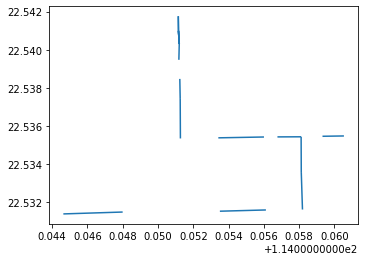

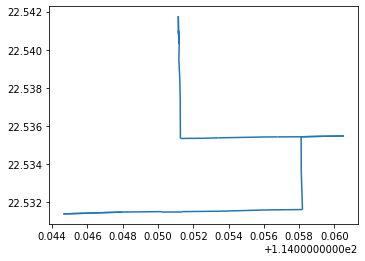

In [6]:
# traj_id=1577

# time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
# opath_list=df_fmm_res.loc[traj_id, "opath"]
# cpath_list=df_fmm_res.loc[traj_id, "cpath"]

# time_list
# opath_list
# cpath_list

# df_edges.loc[opath_list].plot()
# df_edges.loc[cpath_list].plot()

In [7]:
# del_indexes=[]
# for i in range(len(time_list)-1):
#     if opath_list[i]==opath_list[i+1]:
#         del_indexes.append(i+1)

# opath_list=np.delete(opath_list, del_indexes)
# time_list=np.delete(time_list, del_indexes)

# assert(len(opath_list)==len(time_list))
# assert(opath_list[-1]==cpath_list[-1])

# time_list
# opath_list
# cpath_list

array(['2020-06-01T19:00:07.000000000', '2020-06-01T19:01:47.000000000',
       '2020-06-01T19:05:17.000000000', '2020-06-01T19:06:06.000000000',
       '2020-06-01T19:08:07.000000000', '2020-06-01T19:09:47.000000000',
       '2020-06-01T19:10:47.000000000', '2020-06-01T19:12:06.000000000',
       '2020-06-01T19:13:59.000000000', '2020-06-01T19:14:29.000000000',
       '2020-06-01T19:15:07.000000000', '2020-06-01T19:15:46.000000000',
       '2020-06-01T19:17:10.000000000', '2020-06-01T19:23:36.000000000',
       '2020-06-01T19:34:01.000000000'], dtype='datetime64[ns]')

array([444, 456, 474, 473, 234, 459, 451, 425, 168, 328, 326,  80,  81,
       327,  81], dtype=int16)

array([444, 198, 199, 448, 457, 456, 455, 474, 473, 224, 234, 480, 470,
       459, 458, 451, 449, 180, 425, 168, 410, 328, 327, 326,  80,  81,
       327,  81, 327,  81], dtype=int16)

In [13]:
# i=0
# j=0
# recovered_time_list=[]

# while True:
#     if i>len(opath_list)-1:
#         break
#     if opath_list[i]==cpath_list[j]:
#         recovered_time_list.append(time_list[i])
#         i+=1
#         j+=1
#     else:
#         length=0
#         while opath_list[i]!=cpath_list[j]:
#             j+=1
#             length+=1
#         recovered_time_list.extend(gen_time_seq(time_list[i-1], time_list[i], length))
# cpath_list=cpath_list[:j] # fmm bug: trailing
            
# assert(len(recovered_time_list)==len(cpath_list))

# list(zip(cpath_list, recovered_time_list))

[(444, numpy.datetime64('2020-06-01T19:00:07.000000000')),
 (198, numpy.datetime64('2020-06-01T19:00:27.000000000')),
 (199, numpy.datetime64('2020-06-01T19:00:47.000000000')),
 (448, numpy.datetime64('2020-06-01T19:01:07.000000000')),
 (457, numpy.datetime64('2020-06-01T19:01:27.000000000')),
 (456, numpy.datetime64('2020-06-01T19:01:47.000000000')),
 (455, numpy.datetime64('2020-06-01T19:03:32.000000000')),
 (474, numpy.datetime64('2020-06-01T19:05:17.000000000')),
 (473, numpy.datetime64('2020-06-01T19:06:06.000000000')),
 (224, numpy.datetime64('2020-06-01T19:07:06.500000000')),
 (234, numpy.datetime64('2020-06-01T19:08:07.000000000')),
 (480, numpy.datetime64('2020-06-01T19:08:40.333333333')),
 (470, numpy.datetime64('2020-06-01T19:09:13.666666666')),
 (459, numpy.datetime64('2020-06-01T19:09:47.000000000')),
 (458, numpy.datetime64('2020-06-01T19:10:17.000000000')),
 (451, numpy.datetime64('2020-06-01T19:10:47.000000000')),
 (449, numpy.datetime64('2020-06-01T19:11:13.333333333')

In [6]:
# https://stackoverflow.com/questions/35599607/average-date-array-calculation
# https://stackoverflow.com/questions/60949296/how-to-calculate-averages-of-datetime64ns-numpy-ndarray

def gen_time_seq(start_time, end_time, length):
    assert(end_time>start_time)
    
    start_time=start_time.view(np.int64)
    end_time=end_time.view(np.int64)
    
    seq=[]
    step=(end_time-start_time)//(length+1)
    for i in range(length):
        seq.append(start_time+step*(i+1))
    
    return list(np.array(seq, dtype="datetime64[ns]"))

In [ ]:
notify(f"Start {FLOW_AGG_INTERVAL_MINUTE}min recovered dyna.")

N=len(df_edges)

dyna_file=open(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"), "w")
write_length=dyna_file.write("dyna_id,type,time,entity_id,flow\n") # disable printing return value

flow_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)

for traj_id in tqdm(df_fmm_res.index):
    time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
    opath_list=df_fmm_res.loc[traj_id, "opath"]
    cpath_list=df_fmm_res.loc[traj_id, "cpath"]
    
    if len(cpath_list)<2:
        continue
    
    # drop duplicates
    del_indexes=[]
    for i in range(len(time_list)-1):
        if opath_list[i]==opath_list[i+1]:
            del_indexes.append(i+1)

    opath_list=np.delete(opath_list, del_indexes)
    time_list=np.delete(time_list, del_indexes)

    assert(len(opath_list)==len(time_list))
    assert(opath_list[-1]==cpath_list[-1])
    
    # generate recovered time
    i=0
    j=0
    recovered_time_list=[]

    while True:
        if i>len(opath_list)-1:
            break
        if opath_list[i]==cpath_list[j]:
            recovered_time_list.append(time_list[i])
            i+=1
            j+=1
        else:
            length=0
            while opath_list[i]!=cpath_list[j]:
                j+=1
                length+=1
            recovered_time_list.extend(gen_time_seq(time_list[i-1], time_list[i], length))
    cpath_list=cpath_list[:j] # fmm bug: trailing
    assert(len(recovered_time_list)==len(cpath_list))
    
    for i in range(len(cpath_list)):
        time_i=pd.to_datetime(recovered_time_list[i])
        day=time_i.day
        mins=time_i.hour*60+time_i.minute
        
        flow_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=1
        
dyna_id_counter=0
for day in tqdm(range(flow_matrix.shape[0])):
    if day==18 or day==19:
        continue
    for interval in range(flow_matrix.shape[1]):
        for road in range(flow_matrix.shape[2]):
            write_length=dyna_file.write(f"{dyna_id_counter},"+
                    "state,"+
                    f"{DATE_PREFIX}{str(day+START_DAY).zfill(2)}T{str(interval*FLOW_AGG_INTERVAL_MINUTE//60).zfill(2)}:{str((interval%(60//FLOW_AGG_INTERVAL_MINUTE))*FLOW_AGG_INTERVAL_MINUTE).zfill(2)}:00Z,"+
                    f"{road},"+
                    f"{flow_matrix[day][interval][road]}\n")
            dyna_id_counter+=1
            
dyna_file.close()

# delete date 0619, 0620
flow_matrix_no1920=np.delete(flow_matrix, [18, 19], axis=0)

np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.npy"), flow_matrix_no1920)

notify(f"Finish {FLOW_AGG_INTERVAL_MINUTE}min recovered dyna.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    57  100     2  100    55      2     67  0:00:01 --:--:--  0:00:01    69


ok

  0%|          | 707/1996483 [00:12<9:46:10, 56.75it/s] 

In [ ]:
# no recovery

N=len(df_edges)

dyna_file=open(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min.dyna"), "w")
write_length=dyna_file.write("dyna_id,type,time,entity_id,flow\n") # disable printing return value

flow_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)

for traj_id in tqdm(df_fmm_res.index):
    time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
    road_list=df_fmm_res.loc[traj_id, "opath"]
    
    assert(len(time_list)==len(road_list))
    
    for i in range(len(road_list)):
        time_i=pd.to_datetime(time_list[i])
        day=time_i.day
        mins=time_i.hour*60+time_i.minute
        
        flow_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][road_list[i]]+=1
        
dyna_id_counter=0
for day in tqdm(range(flow_matrix.shape[0])):
    if day==18 or day==19:
        continue
    for interval in range(flow_matrix.shape[1]):
        for road in range(flow_matrix.shape[2]):
            write_length=dyna_file.write(f"{dyna_id_counter},"+
                    "state,"+
                    f"{DATE_PREFIX}{str(day+START_DAY).zfill(2)}T{str(interval*FLOW_AGG_INTERVAL_MINUTE//60).zfill(2)}:{str((interval%(60//FLOW_AGG_INTERVAL_MINUTE))*FLOW_AGG_INTERVAL_MINUTE).zfill(2)}:00Z,"+
                    f"{road},"+
                    f"{flow_matrix[day][interval][road]}\n")
            dyna_id_counter+=1
            
dyna_file.close()

# delete date 0619, 0620
flow_matrix_no1920=np.delete(flow_matrix, [18, 19], axis=0)

np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min.npy"), flow_matrix_no1920)

  0%|          | 1112/1996483 [00:21<10:47:47, 51.34it/s]

In [8]:
df_dyna_all=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"))

df_dyna_all=df_dyna_all.sort_values("flow", ascending=False)
df_dyna_all

,dyna_id,type,time,entity_id,flow
51370,51370,state,2020-06-01T08:40:00Z,202,140
615444,615444,state,2020-06-05T08:10:00Z,444,134
618396,618396,state,2020-06-05T08:40:00Z,444,134
617662,617662,state,2020-06-05T08:35:00Z,202,133
51612,51612,state,2020-06-01T08:40:00Z,444,132
...,...,...,...,...,...
2429864,2429864,state,2020-06-18T03:30:00Z,368,0
2429861,2429861,state,2020-06-18T03:30:00Z,365,0
2429856,2429856,state,2020-06-18T03:30:00Z,360,0
2429855,2429855,state,2020-06-18T03:30:00Z,359,0


/home/cseadmin/dz/anaconda3/envs/dz/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='flow', ylabel='Density'>

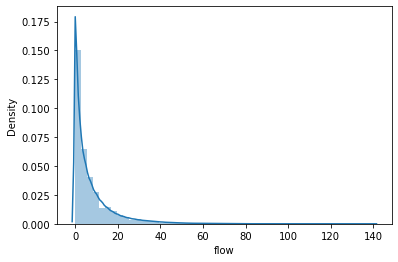

In [9]:
import seaborn as sns
sns.distplot(df_dyna_all["flow"])

In [46]:
# df_dyna=df_dyna_all.loc[(df_dyna_all["time"]<"2020-06-19T00:00:00Z") | (df_dyna_all["time"]>="2020-06-21T00:00:00Z")]

# df_dyna
# df_dyna.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.dyna"), index=False)

,dyna_id,type,time,entity_id,flow
0,0,state,2020-06-01T00:00:00Z,0,24
1,1,state,2020-06-01T00:00:00Z,1,3
2,2,state,2020-06-01T00:00:00Z,2,0
3,3,state,2020-06-01T00:00:00Z,3,0
4,4,state,2020-06-01T00:00:00Z,4,27
...,...,...,...,...,...
1416955,1416955,state,2020-06-30T23:45:00Z,487,0
1416956,1416956,state,2020-06-30T23:45:00Z,488,0
1416957,1416957,state,2020-06-30T23:45:00Z,489,0
1416958,1416958,state,2020-06-30T23:45:00Z,490,0


config

---

In [108]:
import json

config={}

config["geo"]={}
config["geo"]["including_types"]=["LineString"]
config["geo"]["LineString"]={}

config["rel"]={}
config["rel"]["including_types"]=["geo"]
config["rel"]["geo"]={}

config["dyna"]={}
config["dyna"]["including_types"]=["state"]
config["dyna"]["state"]={"entity_id": "geo_id", "flow": "num"}

config["info"]={}
config["info"]["data_files"]=f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered"
config["info"]["geo_file"]=DATASET
config["info"]["rel_file"]=DATASET
config["info"]["data_col"]=["flow"]
config["info"]["output_dim"]=1
# config["info"]["weight_col"]="link_weight"
config["info"]["time_intervals"]=60*FLOW_AGG_INTERVAL_MINUTE
config["info"]["init_weight_inf_or_zero"]="zero" # adj matrix not connected: 0 (inf: infinity)
config["info"]["set_weight_link_or_dist"]="link" # adj matrix 01 (dist: use weight)
config["info"]["calculate_weight_adj"]=False
# config["info"]["weight_adj_epsilon"]=0.1 # disabled when the above is false

json.dump(config, open(os.path.join(DATA_PATH, DATASET, "config.json"), "w", encoding="utf-8"), ensure_ascii=False)
config

{'geo': {'including_types': ['LineString'], 'LineString': {}},
 'rel': {'including_types': ['geo'], 'geo': {}},
 'dyna': {'including_types': ['state'],
  'state': {'entity_id': 'geo_id', 'flow': 'num'}},
 'info': {'data_files': 'sz_taxi_202006_5min_recovered',
  'geo_file': 'sz_taxi_202006',
  'rel_file': 'sz_taxi_202006',
  'data_col': ['flow'],
  'output_dim': 1,
  'time_intervals': 300,
  'init_weight_inf_or_zero': 'zero',
  'set_weight_link_or_dist': 'link',
  'calculate_weight_adj': False}}